## Final Evaluation of Social Bias in Language Model

The model is evaluated using Equalised Odds. Equalised Odds is a fairness metric used to ensures that the model's predictions have the same accuracy across different demographic groups that is both the false positive rate and the true positive rate are the same across protected groups. All packages were downloaded from huggingface and then the Evaluation is done after fine-tuning on the dataset.

In [ ]:
!pip install accelerate
!pip install transformers[torch]
!pip install evaluate
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import json
import numpy as np
import multiprocessing
import os
import torch
import matplotlib.pyplot as plt
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Evaluation of Bias Msc Project/StereoSet-master/data/dev.json")

In [ ]:
# get data for intersentence field for the sentence
intersentence_data = data['data']['intersentence']

# Convert list of dictionaries into dataframe
data = pd.json_normalize(intersentence_data, record_path =['sentences', 'labels'],
                       meta=['id', 'target', 'bias_type', 'context', ['sentences', 'sentence'], ['sentences', 'id']])

In [ ]:
# get data for intrasentence field for the sentence
intrasentence_data = data['data']['intrasentence']

# Convert list of dictionaries into dataframe
data = pd.json_normalize(intrasentence_data, record_path =['sentences', 'labels'],
                       meta=['id', 'target', 'bias_type', 'context', ['sentences', 'sentence'], ['sentences', 'id']])

In [ ]:
label_map = {
    'anti-stereotype': 0,
    'stereotype': 1,
    'unrelated': 2,
    'related': 3
}

data['encoded_text'] = data['label'].replace(label_map)

<ipython-input-6-e48ef233fe3e>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['encoded_text'] = data['label'].replace(label_map)


In [ ]:
from evaluate import load
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#convert into integer labels
sentences = data['sentences.sentence'].tolist()
labels = pd.Categorical(data['label']).codes

#EVALUATION FOR BERT-BASE

In [ ]:
import tensorflow_hub as hub
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BartForSequenceClassification

In [ ]:
'''This library calls the pre-trained bert-base-uncased model from hugging face which defines the
architecture used in the original BERT model. "bert-base-uncased" has 12 transformer layers (or blocks)
with 768 hidden units in each layer. BertForSequenceClassification uses the architecture of the pre-trained
BERT model and appends a classification head on top of it.
'''

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# The Tokenizer splits the text into tokens
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
bias_type_count = data ['bias_type'].value_counts()
bias_check = bias_type_count.index
bias_check
bias_type_count

,count
bias_type,
race,14640
profession,12405
gender,3630
religion,1170


In [ ]:
# The below split the data in the bias-type column (Gender, Profession, Race and Religion)
gender_data = data[data['bias_type'] == 'gender']
prof_data = data[data['bias_type'] == 'profession']
race_data = data[data['bias_type'] == 'race']
rel_data = data[data['bias_type'] == 'religion']

# Split data into train, val, and test
def split_data(df):
    train, temp = train_test_split(df, test_size=0.2, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)
    return train, val, test

gender_train, gender_val, gender_test = split_data(gender_data)
prof_train, prof_val, prof_test = split_data(prof_data)
race_train, race_val, race_test = split_data(race_data)
rel_train, rel_val, rel_test = split_data(rel_data)

In [ ]:
# Tokenize the training, validation and Test data
def tokenize_data(train, val, test):
    train_token = tokenizer(train['sentences.sentence'].tolist(), truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    val_token = tokenizer(val['sentences.sentence'].tolist(), truncation=True, padding='max_length', max_length=512, return_tensors="pt")
    test_token = tokenizer(test['sentences.sentence'].tolist(), truncation=True, padding='max_length', max_length=512, return_tensors="pt")

    train_labels = train['label'].tolist()
    val_labels = val['label'].tolist()
    test_labels = test['label'].tolist()
    return train_token, val_token, test_token, train_labels, val_labels, test_labels

# Evaluate the data
gender_train_token, gender_val_token, gender_test_token, gender_train_labels, gender_val_labels, gender_test_labels = tokenize_data(gender_train, gender_val, gender_test)
prof_train_token, prof_val_token, prof_test_token, prof_train_labels, prof_val_labels, prof_test_labels = tokenize_data(prof_train, prof_val, prof_test)
race_train_token, race_val_token, race_test_token, race_train_labels, race_val_labels, race_test_labels = tokenize_data(race_train, race_val, race_test)
rel_train_token, rel_val_token, rel_test_token, rel_train_labels, rel_val_labels, rel_test_labels = tokenize_data(rel_train, rel_val, rel_test)


In [ ]:
# Resizing all length of each domain to make it equivalent
small_length = min(len(gender_train_labels), len(prof_train_labels), len(race_train_labels), len(rel_train_labels))
gender_train_labels = gender_train_labels[:small_length]
prof_train_labels = prof_train_labels[:small_length]
race_train_labels = race_train_labels[:small_length]
rel_train_labels = rel_train_labels[:small_length]

In [ ]:
#Reduce the length of each dictionary list to match the smallest_length.
gender_train_token = {key: val[:small_length] for key, val in gender_train_token.items()}
prof_train_token = {key: val[:small_length] for key, val in prof_train_token.items()}
race_train_token = {key: val[:small_length] for key, val in race_train_token.items()}
rel_train_token = {key: val[:small_length] for key, val in rel_train_token.items()}

In [ ]:
#Mapping all labels to indices
all_labels = list(set(gender_train_labels))
label_map = {label: idx for idx, label in enumerate(all_labels)}
gender_labels = [label_map[label] for label in gender_train_labels]
prof_labels = [label_map[label] for label in prof_train_labels]
race_labels = [label_map[label] for label in race_train_labels]
rel_labels = [label_map[label] for label in rel_train_labels]
print(all_labels)

['related', 'unrelated', 'stereotype', 'anti-stereotype']


In [ ]:
# Define the dataset that will be processed by BERT
from torch.utils.data import Dataset
class BertDataset(Dataset):
    def __init__(self, encodings, labels, label_map):
        self.encodings = encodings
        self.labels = labels
        self.label_map = label_map

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.label_map[self.labels[idx]], dtype=torch.long)
        }
        return item

In [ ]:
#Prepare data in a format suitable for BERT
train_dataset = BertDataset(gender_train_token, gender_train_labels, label_map)
val_dataset = BertDataset(gender_val_token, gender_val_labels, label_map)
test_dataset = BertDataset(gender_test_token,  gender_test_labels, label_map)

<ipython-input-18-a900bec297d6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_ids = torch.tensor(self.tokens['input_ids'], dtype=torch.long)
<ipython-input-18-a900bec297d6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.attention_mask = torch.tensor(self.tokens['attention_mask'], dtype=torch.long)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
def compute_metrics(eval_pred):
   load_accuracy = load("accuracy")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   return {"accuracy": accuracy}

In [ ]:
training_args = TrainingArguments(
   output_dir= "./result",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.4025624593098958, metrics={'train_runtime': 1311.2849, 'train_samples_per_second': 2.141, 'train_steps_per_second': 0.135, 'total_flos': 49062870619776.0, 'train_loss': 0.4025624593098958, 'epoch': 3.0})

In [ ]:
# Save the model
trainer.save_model("./model_output")

In [ ]:
trainer.evaluate

<bound method Trainer.evaluate of <transformers.trainer.Trainer object at 0x7b88f02910f0>>

In [ ]:
# Predict on Test Set
predictions = trainer.predict(test_dataset)
gender_pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)


## Training for Profession

In [ ]:
train_dataset = BertDataset(prof_train_token, prof_train_labels, label_map)
val_dataset = BertDataset(prof_val_token, prof_val_labels, label_map)
test_dataset = BertDataset(prof_test_token, prof_test_labels, label_map)

<ipython-input-18-a900bec297d6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_ids = torch.tensor(self.tokens['input_ids'], dtype=torch.long)
<ipython-input-18-a900bec297d6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.attention_mask = torch.tensor(self.tokens['attention_mask'], dtype=torch.long)


In [ ]:
training_args = TrainingArguments(
   output_dir= "./result",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.6987898228532177, metrics={'train_runtime': 1402.9129, 'train_samples_per_second': 2.002, 'train_steps_per_second': 0.126, 'total_flos': 51948921832704.0, 'train_loss': 0.6987898228532177, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7465697526931763,
 'eval_accuracy': 0.6846774193548387,
 'eval_runtime': 157.5017,
 'eval_samples_per_second': 7.873,
 'eval_steps_per_second': 0.495,
 'epoch': 3.0}

In [ ]:
# Predict on Test Set
predictions = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

## Training for Race Bias_Type

In [ ]:
train_dataset = BertDataset(race_train_token, race_train_labels, label_map)
val_dataset = BertDataset(race_val_token, race_val_labels, label_map)
test_dataset = BertDataset(race_test_token, race_test_labels, label_map)

<ipython-input-18-a900bec297d6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.input_ids = torch.tensor(self.tokens['input_ids'], dtype=torch.long)
<ipython-input-18-a900bec297d6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.attention_mask = torch.tensor(self.tokens['attention_mask'], dtype=torch.long)


In [ ]:
training_args = TrainingArguments(
   output_dir= "./result",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="epoch",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.6634821487685382, metrics={'train_runtime': 1580.0648, 'train_samples_per_second': 1.777, 'train_steps_per_second': 0.112, 'total_flos': 62050101077952.0, 'train_loss': 0.6634821487685382, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7262661457061768,
 'eval_accuracy': 0.7247267759562842,
 'eval_runtime': 226.396,
 'eval_samples_per_second': 6.467,
 'eval_steps_per_second': 0.406,
 'epoch': 3.0}

In [ ]:
# Predict on Test Set
predictions = trainer.predict(test_dataset)
race_pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

#Training for Religious

In [ ]:
train_dataset = BertDataset(rel_train_token, rel_train_labels, label_map)
val_dataset = BertDataset(rel_val_token, rel_val_labels, label_map)
test_dataset = BertDataset(rel_test_token,  rel_test_labels, label_map)

In [ ]:
training_args = TrainingArguments(
   output_dir= "./result",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.6880872909632106, metrics={'train_runtime': 1025.7483, 'train_samples_per_second': 2.738, 'train_steps_per_second': 0.173, 'total_flos': 37004303875968.0, 'train_loss': 0.6880872909632106, 'epoch': 3.0})

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.4385419080486405, metrics={'train_runtime': 1038.4265, 'train_samples_per_second': 2.704, 'train_steps_per_second': 0.17, 'total_flos': 31746563342208.0, 'train_loss': 0.4385419080486405, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7420422434806824,
 'eval_accuracy': 0.8376068376068376,
 'eval_runtime': 7.8264,
 'eval_samples_per_second': 14.949,
 'eval_steps_per_second': 1.022,
 'epoch': 3.0}

In [ ]:
# Predict on Test Set
'''predictions = trainer.predict(test_dataset)
rel_pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()'''

'predictions = trainer.predict(test_dataset) \nrel_pred_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()'

In [ ]:
# Compute Accuracy
accuracy = (rel_pred_labels == test_dataset.labels).mean()
print(f"Accuracy on Test Set: {accuracy:.4f}")

#Evaluation using Equalised Odds

In [ ]:
# Convert string labels to numeric format
prof_test_labels = [label_map[label] for label in prof_test_labels]
pred_labels = [label_map[label.item()] for label in pred_labels]


In [ ]:
# Convert the race_test_labels
race_test_labels = [label_map[label] for label in race_test_labels]
race_pred_labels = [label.item() for label in race_pred_labels]

In [ ]:
gender_test_labels = [label_map[label] for label in gender_test_labels]
gender_pred_labels = [label.item() for label in gender_pred_labels]

In [ ]:
rel_test_labels = [label_map[label] for label in rel_test_labels]
rel_pred_labels = [label.item() for label in rel_pred_labels]

'rel_test_labels = [label_map[label] for label in rel_test_labels]\nrel_pred_labels = [label.item() for label in rel_pred_labels]'

In [ ]:
# Define a function to get TPR and FPR
from sklearn.metrics import confusion_matrix
def get_rates(labels, predictions, positive_class=1):
    cm = confusion_matrix(labels, predictions)
    tpr = cm[1,1] / (cm[1,1] + cm[1,0])
    fpr = cm[0,1] / (cm[0,0] + cm[0,1])
    return tpr, fpr

prof_tpr, prof_fpr = get_rates(prof_test_labels, pred_labels)
race_tpr, race_fpr = get_rates(race_test_labels, race_pred_labels)

# Print out the TPR and FPR values
print(f"Prof: TPR = {prof_tpr:.3f}, FPR = {prof_fpr:.3f}")
print(f"Race: TPR = {race_tpr:.3f}, FPR = {race_fpr:.3f}")

# Given this Equalized odds condition, print the final output
threshold = 0.1
if abs(prof_tpr - race_tpr) < threshold and abs(prof_fpr - race_fpr) < threshold:
    print("Equalized Odds Satisfied!")
else:
    print("Equalized Odds Not Satisfied!")

Gender: TPR = 0.521, FPR = 0.234
Race: TPR = 0.640, FPR = 0.231
Equalized Odds Not Satisfied!


In [ ]:
# Define a function to get TPR and FPR
from sklearn.metrics import confusion_matrix
def get_rates(labels, predictions, positive_class=1):
    cm = confusion_matrix(labels, predictions)
    tpr = cm[1,1] / (cm[1,1] + cm[1,0])
    fpr = cm[0,1] / (cm[0,0] + cm[0,1])
    return tpr, fpr

gender_tpr, gender_fpr = get_rates(gender_test_labels, gender_pred_labels)
rel_tpr, rel_fpr = get_rates(rel_test_labels, rel_pred_labels)

# Print out the TPR and FPR values
print(f"Gender: TPR = {gender_tpr:.3f}, FPR = {gender_fpr:.3f}")
print(f"Rel: TPR = {rel_tpr:.3f}, FPR = {rel_fpr:.3f}")

# Given this Equalized odds condition, print the final output
threshold = 0.1
if abs(gender_tpr - rel_tpr) < threshold and abs(gender_fpr - rel_fpr) < threshold:
    print("Equalized Odds Satisfied!")
else:
    print("Equalized Odds Not Satisfied!")

Gender: TPR = 0.628, FPR = 0.165
Rel: TPR = 0.521, FPR = 0.234
Equalized Odds Not Satisfied!


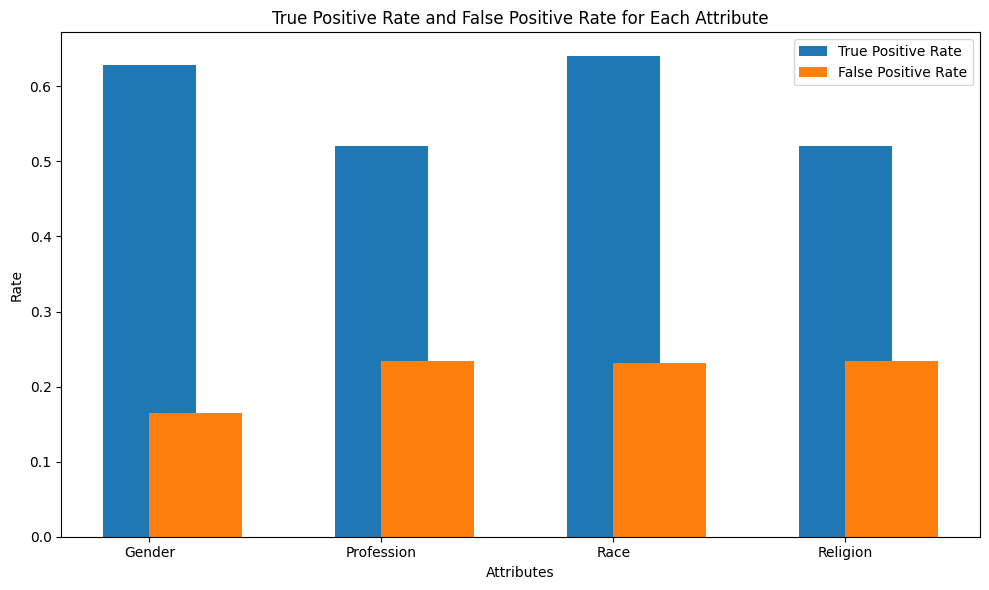

In [ ]:
# Attributes and their corresponding TPR and FPR values
attributes = [ 'Gender', 'Profession', 'Race', 'Religion']
tpr_values = [0.628, 0.521, 0.640, 0.521]
fpr_values = [0.165, 0.234, 0.231, 0.234]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot TPR and FPR for each attribute
ax.bar(attributes, tpr_values, width=0.4, label='True Positive Rate', align='center')
ax.bar(attributes, fpr_values, width=0.4, label='False Positive Rate', align='edge')

# Set the title and labels
ax.set_title('True Positive Rate and False Positive Rate for Each Attribute')
ax.set_xlabel('Attributes')
ax.set_ylabel('Rate')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

#Evaluating BART-BASE

In [ ]:
from transformers import BartTokenizer, BartForSequenceClassification, Trainer, TrainingArguments
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForSequenceClassification.from_pretrained(model_name, num_labels=4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
encodings = tokenizer(
    sentences,
    padding='max_length',
    truncation=True,
    max_length=512,
    return_tensors='pt'
)

In [ ]:
# Define the dataset that will be processed by BART
from torch.utils.data import Dataset
class BartDataset(Dataset):
    def __init__(self, encodings, labels, label_map):
        self.encodings = encodings
        self.labels = labels
        self.label_map = label_map

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.label_map[self.labels[idx]], dtype=torch.long)
        }
        return item

In [ ]:
#Prepare data in a format suitable for BART
train_dataset = BartDataset(gender_train_token, gender_train_labels, label_map)
val_dataset = BartDataset(gender_val_token, gender_val_labels, label_map)
test_dataset = BartDataset(gender_test_token,  gender_test_labels, label_map)

In [ ]:
# Create DataLoader
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# List to store the predicted labels
gender_predictions = []

with torch.no_grad():
    for batch in val_dataloader:
        # Move tensors to the same device as the model
        batch = {k: v.to(model.device) for k, v in batch.items()}
        outputs = model(**batch)
        predicted_labels = torch.argmax(outputs.logits, dim=-1)
        gender_predictions.append(predicted_labels.cpu().numpy())

gender_predictions = np.concatenate(gender_predictions, axis=0)

In [ ]:
def compute_metrics(eval_pred):
   load_accuracy = load("accuracy")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   return {"accuracy": accuracy}

In [ ]:
training_args = TrainingArguments(
   output_dir= "./bartresult",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-25-56c8887bad55>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.8617488192973164, metrics={'train_runtime': 371.0216, 'train_samples_per_second': 7.568, 'train_steps_per_second': 0.477, 'total_flos': 861191072022528.0, 'train_loss': 0.8617488192973164, 'epoch': 3.0})

In [ ]:
# Set model to evaluation mode
model.eval()

# Track predictions and labels for evaluation
gender_preds_val = []
gender_labels_val = []

with torch.no_grad():
    # Evaluate on Validation Set
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)

        # Get the logits and convert to predicted labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        gender_preds_val.extend(preds.cpu().numpy())
        gender_labels_val.extend(batch["labels"].cpu().numpy())

# Calculate accuracy for gender prediction
accuracy_val = accuracy_score(gender_labels_val, gender_preds_val)
print(f"Validation Gender Prediction Accuracy: {accuracy_val:.4f}")

Validation Gender Prediction Accuracy: 0.7300


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
gender_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]

        # Add batch dimension (unsqueeze) and move to the device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        gender_predictions.append(preds.cpu().numpy())

In [ ]:
gender_predictions = np.concatenate(gender_predictions, axis=0)

In [ ]:
gender_test_labels = [label_map[label] for label in gender_test_labels]
gender_predictions = [label.item() for label in gender_predictions]

Evaluation of Profession Label

In [ ]:
train_dataset = BartDataset(prof_train_token, prof_train_labels, label_map)
val_dataset = BartDataset(prof_val_token, prof_val_labels, label_map)
test_dataset = BartDataset(prof_test_token, prof_test_labels, label_map)

In [ ]:
training_args = TrainingArguments(
   output_dir= "./bartresult",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-56c8887bad55>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.8262964453400865, metrics={'train_runtime': 373.9658, 'train_samples_per_second': 7.509, 'train_steps_per_second': 0.473, 'total_flos': 861191072022528.0, 'train_loss': 0.8262964453400865, 'epoch': 3.0})

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# Set model to evaluation mode
model.eval()

# Track predictions and labels for evaluation
prof_preds_val = []
prof_labels_val = []

with torch.no_grad():
    # Evaluate on Validation Set
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)

        # Get the logits and convert to predicted labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        prof_preds_val.extend(preds.cpu().numpy())
        prof_labels_val.extend(batch["labels"].cpu().numpy())

# Calculate accuracy for gender prediction
accuracy_val = accuracy_score(prof_labels_val, prof_preds_val)
print(f"Validation Prof Prediction Accuracy: {accuracy_val:.4f}")

Validation Prof Prediction Accuracy: 0.7607


In [ ]:
#Track predictions for test set
prof_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]

        # Add batch dimension (unsqueeze) and move to the device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        prof_predictions.append(preds.cpu().numpy())

In [ ]:
prof_predictions = [pred.item() if hasattr(pred, 'item') else pred for pred in prof_predictions]

In [ ]:
prof_test_labels = [str(label) for label in prof_test_labels]
prof_predictions = [str(label) for label in prof_predictions]

Evaluation of Race Label

In [ ]:
train_dataset = BartDataset(race_train_token, race_train_labels, label_map)
val_dataset = BartDataset(race_val_token, race_val_labels, label_map)
test_dataset = BartDataset(race_test_token, race_test_labels, label_map)

In [ ]:
training_args = TrainingArguments(
   output_dir= "./bartresult",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-38-56c8887bad55>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.6947852959067135, metrics={'train_runtime': 293.9076, 'train_samples_per_second': 9.554, 'train_steps_per_second': 0.602, 'total_flos': 861191072022528.0, 'train_loss': 0.6947852959067135, 'epoch': 3.0})

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# Set model to evaluation mode
model.eval()

# Track predictions and labels for evaluation
race_preds_val = []
race_labels_val = []

with torch.no_grad():
    # Evaluate on Validation Set
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)

        # Get the logits and convert to predicted labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        race_preds_val.extend(preds.cpu().numpy())
        race_labels_val.extend(batch["labels"].cpu().numpy())

# Calculate accuracy for gender prediction
accuracy_val = accuracy_score(race_labels_val, race_preds_val)
print(f"Validation Race Prediction Accuracy: {accuracy_val:.4f}")

Validation Race Prediction Accuracy: 0.7281


In [ ]:
#Track predictions for test set
race_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]

        # Add batch dimension (unsqueeze) and move to the device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        race_predictions.append(preds.cpu().numpy())

In [ ]:
# Convert the race_test_labels
race_test_labels = [label_map[label] for label in race_test_labels]
race_predictions = [label.item() for label in race_predictions]

Evaluation for Religion Label

In [ ]:
train_dataset = BartDataset(rel_train_token, rel_train_labels, label_map)
val_dataset = BartDataset(rel_val_token, rel_val_labels, label_map)
test_dataset = BartDataset(rel_test_token,  rel_test_labels, label_map)

In [ ]:
training_args = TrainingArguments(
   output_dir= "./bartresult",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-61-56c8887bad55>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.7214415814243468, metrics={'train_runtime': 305.1675, 'train_samples_per_second': 9.202, 'train_steps_per_second': 0.58, 'total_flos': 861191072022528.0, 'train_loss': 0.7214415814243468, 'epoch': 3.0})

In [ ]:
# Set model to evaluation mode
model.eval()

# Track predictions and labels for evaluation
rel_preds_val = []
rel_labels_val = []

with torch.no_grad():
    # Evaluate on Validation Set
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)

        # Get the logits and convert to predicted labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        rel_preds_val.extend(preds.cpu().numpy())
        rel_labels_val.extend(batch["labels"].cpu().numpy())

# Calculate accuracy for gender prediction
accuracy_val = accuracy_score(rel_labels_val, rel_preds_val)
print(f"Validation Rel Prediction Accuracy: {accuracy_val:.4f}")

Validation Rel Prediction Accuracy: 0.7507


In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
 #Track predictions for test set
rel_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]

        # Add batch dimension (unsqueeze) and move to the device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        rel_predictions.append(preds.cpu().numpy())

In [ ]:
rel_test_labels = [label_map[label] for label in rel_test_labels]
rel_predictions = [label.item() for label in rel_predictions]

#Evaluation BART-Base using Equalized Odds

In [ ]:
# Setting Labels and predictions to same length
def align_labels_predictions(labels, predictions):
    min_length = min(len(labels), len(predictions))
    return labels[:min_length], predictions[:min_length]

# Define a function to get TPR and FPR
def get_rates(labels, predictions, positive_class=1):
    # Align labels and predictions
    labels, predictions = align_labels_predictions(labels, predictions)
    cm = confusion_matrix(labels, predictions)
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) != 0 else 0
    fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
    return tpr, fpr

# Align labels and predictions for all categories
gender_test_labels, gender_predictions = align_labels_predictions(gender_test_labels, gender_predictions)
rel_test_labels, rel_predictions = align_labels_predictions(rel_test_labels, rel_predictions)

# Calculate TPR and FPR for each category
gender_tpr, gender_fpr = get_rates(gender_test_labels, gender_predictions)
rel_tpr, rel_fpr = get_rates(rel_test_labels, rel_predictions)

# Print out the TPR and FPR values
print(f"Gender: TPR = {gender_tpr:.3f}, FPR = {gender_fpr:.3f}")
print(f"Religion: TPR = {rel_tpr:.3f}, FPR = {rel_fpr:.3f}")

# Given this Equalized odds condition, print the final output
threshold = 0.1

# Check Equalized Odds between gender and religion
if abs(gender_tpr - rel_tpr) < threshold and abs(gender_fpr - rel_fpr) < threshold:
    print("Equalized Odds Satisfied between Gender and Religion!")
else:
    print("Equalized Odds Not Satisfied between Gender and Religion!")

Gender: TPR = 0.000, FPR = 0.000
Religion: TPR = 0.000, FPR = 0.000
Equalized Odds Satisfied between Gender and Religion!


In [ ]:
# Setting Labels and predictions to same length
def align_labels_predictions(labels, predictions):
    min_length = min(len(labels), len(predictions))
    return labels[:min_length], predictions[:min_length]

# Define a function to get TPR and FPR
def get_rates(labels, predictions, positive_class=1):
    # Align labels and predictions
    labels, predictions = align_labels_predictions(labels, predictions)
    cm = confusion_matrix(labels, predictions)
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) != 0 else 0
    fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
    return tpr, fpr

prof_tpr, prof_fpr = get_rates(prof_test_labels, prof_predictions)
race_tpr, race_fpr = get_rates(race_test_labels, race_predictions)

# Print out the TPR and FPR values
print(f"Prof: TPR = {prof_tpr:.3f}, FPR = {prof_fpr:.3f}")
print(f"Race: TPR = {race_tpr:.3f}, FPR = {race_fpr:.3f}")

# Given this Equalized odds condition, print the final output
threshold = 0.1

if abs(prof_tpr - race_tpr) < threshold and abs(prof_fpr - race_fpr) < threshold:
    print("Equalized Odds Satisfied between Prof and Race!")
else:
    print("Equalized Odds Not Satisfied between Prof and Race!")

Prof: TPR = 0.634, FPR = 0.295
Race: TPR = 0.703, FPR = 0.238
Equalized Odds Satisfied between Prof and Race!


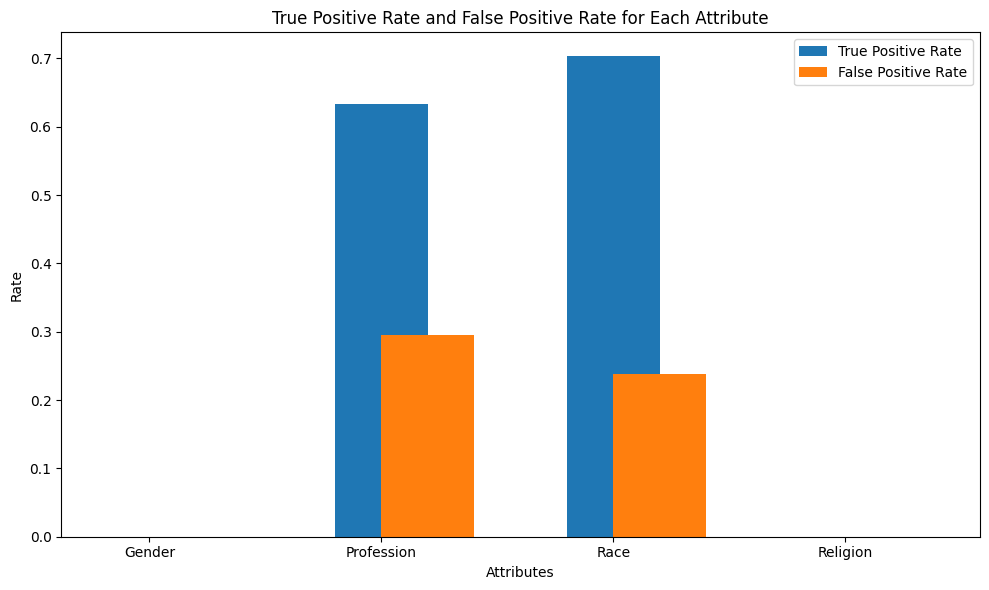

In [ ]:
# Attributes and their corresponding TPR and FPR values
attributes = [ 'Gender', 'Profession', 'Race', 'Religion']
tpr_values = [0.000, 0.634, 0.703, 0.000]
fpr_values = [0.000, 0.295, 0.238, 0.000]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot TPR and FPR for each attribute
ax.bar(attributes, tpr_values, width=0.4, label='True Positive Rate', align='center')
ax.bar(attributes, fpr_values, width=0.4, label='False Positive Rate', align='edge')

# Set the title and labels
ax.set_title('True Positive Rate and False Positive Rate for Each Attribute')
ax.set_xlabel('Attributes')
ax.set_ylabel('Rate')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

#Evaluation on RoBERTa-Base Model

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the dataset that will be processed by RoBERTa
from torch.utils.data import Dataset
class RoBertaDataset(Dataset):
    def __init__(self, encodings, labels, label_map):
        self.encodings = encodings
        self.labels = labels
        self.label_map = label_map

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.label_map[self.labels[idx]], dtype=torch.long)
        }
        return item

In [ ]:
#Prepare data in a format suitable for BART
train_dataset = RoBertaDataset(gender_train_token, gender_train_labels, label_map)
val_dataset = RoBertaDataset(gender_val_token, gender_val_labels, label_map)
test_dataset = RoBertaDataset(gender_test_token,  gender_test_labels, label_map)

In [ ]:
training_args = TrainingArguments(
   output_dir= "./bartresult",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-117-56c8887bad55>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.9584254033147952, metrics={'train_runtime': 239.9873, 'train_samples_per_second': 11.701, 'train_steps_per_second': 0.738, 'total_flos': 738829110509568.0, 'train_loss': 0.9584254033147952, 'epoch': 3.0})

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Set model to evaluation mode
model.eval()

# Track predictions and labels for evaluation
gender_preds_val = []
gender_labels_val = []

with torch.no_grad():
    # Evaluate on Validation Set
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)

        # Get the logits and convert to predicted labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        gender_preds_val.extend(preds.cpu().numpy())
        gender_labels_val.extend(batch["labels"].cpu().numpy())

# Calculate accuracy for gender prediction
accuracy_val = accuracy_score(gender_labels_val, gender_preds_val)
print(f"Validation Gender Prediction Accuracy: {accuracy_val:.4f}")

Validation Gender Prediction Accuracy: 0.7493


In [ ]:
 #Track predictions for test set
gender_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]

        # Add batch dimension (unsqueeze) and move to the device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        gender_predictions.append(preds.cpu().numpy())

In [ ]:
gender_predictions = [pred.item() if hasattr(pred, 'item') else pred for pred in gender_predictions]

In [ ]:
gender_test_labels = [str(label) for label in gender_test_labels]
gender_predictions = [str(label) for label in gender_predictions]

In [ ]:
gender_test_labels = [label_map[label] for label in gender_test_labels]
gender_predictions = [label.item() for label in gender_predictions]

Evaluation for Profession Label

In [ ]:
train_dataset = RoBertaDataset(prof_train_token, prof_train_labels, label_map)
val_dataset = RoBertaDataset(prof_val_token, prof_val_labels, label_map)
test_dataset = RoBertaDataset(prof_test_token, prof_test_labels, label_map)

In [ ]:
training_args = TrainingArguments(
   output_dir= "./bartresult",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-56c8887bad55>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.8545821884931144, metrics={'train_runtime': 389.4558, 'train_samples_per_second': 7.21, 'train_steps_per_second': 0.454, 'total_flos': 738829110509568.0, 'train_loss': 0.8545821884931144, 'epoch': 3.0})

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Set model to evaluation mode
model.eval()

# Track predictions and labels for evaluation
prof_preds_val = []
prof_labels_val = []

with torch.no_grad():
    # Evaluate on Validation Set
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)

        # Get the logits and convert to predicted labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        prof_preds_val.extend(preds.cpu().numpy())
        prof_labels_val.extend(batch["labels"].cpu().numpy())

# Calculate accuracy for gender prediction
accuracy_val = accuracy_score(prof_labels_val, prof_preds_val)
print(f"Validation Prof Prediction Accuracy: {accuracy_val:.4f}")

Validation Prof Prediction Accuracy: 0.6694


In [ ]:
 #Track predictions for test set
prof_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]

        # Add batch dimension (unsqueeze) and move to the device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        prof_predictions.append(preds.cpu().numpy())

In [ ]:
prof_test_labels = [label_map[label] for label in prof_test_labels]
prof_predictions = [label.item() for label in prof_predictions]

Evaluation of Race Label

In [ ]:
train_dataset = RoBertaDataset(race_train_token, race_train_labels, label_map)
val_dataset = RoBertaDataset(race_val_token, race_val_labels, label_map)
test_dataset = RoBertaDataset(race_test_token, race_test_labels, label_map)

In [ ]:
training_args = TrainingArguments(
   output_dir= "./bartresult",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-29-56c8887bad55>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.676534146238855, metrics={'train_runtime': 247.841, 'train_samples_per_second': 11.33, 'train_steps_per_second': 0.714, 'total_flos': 738829110509568.0, 'train_loss': 0.676534146238855, 'epoch': 3.0})

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Set model to evaluation mode
model.eval()

# Track predictions and labels for evaluation
race_preds_val = []
race_labels_val = []

with torch.no_grad():
    # Evaluate on Validation Set
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)

        # Get the logits and convert to predicted labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        race_preds_val.extend(preds.cpu().numpy())
        race_labels_val.extend(batch["labels"].cpu().numpy())

# Calculate accuracy for gender prediction
accuracy_val = accuracy_score(race_labels_val, race_preds_val)
print(f"Validation Race Prediction Accuracy: {accuracy_val:.4f}")

Validation Race Prediction Accuracy: 0.7322


In [ ]:
 #Track predictions for test set
race_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]

        # Add batch dimension (unsqueeze) and move to the device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        race_predictions.append(preds.cpu().numpy())

In [ ]:
race_test_labels = [label_map[label] for label in race_test_labels]
race_predictions = [label.item() for label in race_predictions]

Evaluation of Rel Label

In [ ]:
train_dataset = RoBertaDataset(rel_train_token, rel_train_labels, label_map)
val_dataset = RoBertaDataset(rel_val_token, rel_val_labels, label_map)
test_dataset = RoBertaDataset(rel_test_token,  rel_test_labels, label_map)

In [ ]:
training_args = TrainingArguments(
   output_dir= "./bartresult",
   learning_rate=2e-5,
   logging_dir='./logs',
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=3,
   weight_decay=0.01,
   save_strategy="no",
   evaluation_strategy="steps",
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=train_dataset,
   eval_dataset=val_dataset,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-90-56c8887bad55>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=177, training_loss=0.6497756613176421, metrics={'train_runtime': 238.548, 'train_samples_per_second': 11.771, 'train_steps_per_second': 0.742, 'total_flos': 738829110509568.0, 'train_loss': 0.6497756613176421, 'epoch': 3.0})

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Set model to evaluation mode
model.eval()

# Track predictions and labels for evaluation
rel_preds_val = []
rel_labels_val = []

with torch.no_grad():
    # Evaluate on Validation Set
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)

        # Get the logits and convert to predicted labels
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        rel_preds_val.extend(preds.cpu().numpy())
        rel_labels_val.extend(batch["labels"].cpu().numpy())

# Calculate accuracy for gender prediction
accuracy_val = accuracy_score(rel_labels_val, rel_preds_val)
print(f"Validation Rel Prediction Accuracy: {accuracy_val:.4f}")

Validation Rel Prediction Accuracy: 0.6911


In [ ]:
 #Track predictions for test set
rel_predictions = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        batch = test_dataset[i]

        # Add batch dimension (unsqueeze) and move to the device
        batch = {k: v.unsqueeze(0).to(model.device) for k, v in batch.items()}

        # Get model predictions
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        rel_predictions.append(preds.cpu().numpy())

In [ ]:
rel_predictions = [pred.item() if hasattr(pred, 'item') else pred for pred in rel_predictions]

In [ ]:
rel_test_labels = [str(label) for label in rel_test_labels]
rel_predictions = [str(label) for label in rel_predictions]

In [ ]:
rel_test_labels = [label_map[label] for label in rel_test_labels]
rel_predictions = [label.item() for label in rel_predictions]

#Evaluation using Equalised Odds

In [ ]:
# Setting Labels and predictions to same length
def align_labels_predictions(labels, predictions):
    min_length = min(len(labels), len(predictions))
    return labels[:min_length], predictions[:min_length]

# Define a function to get TPR and FPR
def get_rates(labels, predictions, positive_class=1):
    # Align labels and predictions
    labels, predictions = align_labels_predictions(labels, predictions)
    cm = confusion_matrix(labels, predictions)
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) != 0 else 0
    fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
    return tpr, fpr

# Align labels and predictions for all categories
gender_test_labels, gender_predictions = align_labels_predictions(gender_test_labels, gender_predictions)
rel_test_labels, rel_predictions = align_labels_predictions(rel_test_labels, rel_predictions)

# Calculate TPR and FPR for each category
gender_tpr, gender_fpr = get_rates(gender_test_labels, gender_predictions)
rel_tpr, rel_fpr = get_rates(rel_test_labels, rel_predictions)

# Print out the TPR and FPR values
print(f"Gender: TPR = {gender_tpr:.3f}, FPR = {gender_fpr:.3f}")
print(f"Religion: TPR = {rel_tpr:.3f}, FPR = {rel_fpr:.3f}")

# Given this Equalized odds condition, print the final output
threshold = 0.1

# Check Equalized Odds between gender and religion
if abs(gender_tpr - rel_tpr) < threshold and abs(gender_fpr - rel_fpr) < threshold:
    print("Equalized Odds Satisfied between Gender and Religion!")
else:
    print("Equalized Odds Not Satisfied between Gender and Religion!")

Gender: TPR = 0.239, FPR = 0.071
Religion: TPR = 0.879, FPR = 0.182
Equalized Odds Not Satisfied between Gender and Religion!


In [ ]:
from sklearn.metrics import confusion_matrix
# Setting Labels and predictions to same length
def align_labels_predictions(labels, predictions):
    min_length = min(len(labels), len(predictions))
    return labels[:min_length], predictions[:min_length]

# Define a function to get TPR and FPR
def get_rates(labels, predictions, positive_class=1):
    # Align labels and predictions
    labels, predictions = align_labels_predictions(labels, predictions)
    cm = confusion_matrix(labels, predictions)
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) != 0 else 0
    fpr = cm[0, 1] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) != 0 else 0
    return tpr, fpr

# Align labels and predictions for all categories
prof_test_labels, prof_predictions = align_labels_predictions(prof_test_labels, prof_predictions)
race_test_labels, race_predictions = align_labels_predictions(race_test_labels, race_predictions)

# Calculate TPR and FPR for each category
prof_tpr, prof_fpr = get_rates(prof_test_labels, prof_predictions)
race_tpr, race_fpr = get_rates(race_test_labels, race_predictions)

# Print out the TPR and FPR values
print(f"Prof: TPR = {prof_tpr:.3f}, FPR = {prof_fpr:.3f}")
print(f"Race: TPR = {race_tpr:.3f}, FPR = {race_fpr:.3f}")

# Given this Equalized odds condition, print the final output
threshold = 0.1

# Check Equalized Odds between gender and religion
if abs(prof_tpr - race_tpr) < threshold and abs(prof_fpr - race_fpr) < threshold:
    print("Equalized Odds Satisfied between Prof and Race!")
else:
    print("Equalized Odds Not Satisfied between Prof and Race!")

Prof: TPR = 1.000, FPR = 1.000
Race: TPR = 1.000, FPR = 1.000
Equalized Odds Satisfied between Prof and Race!


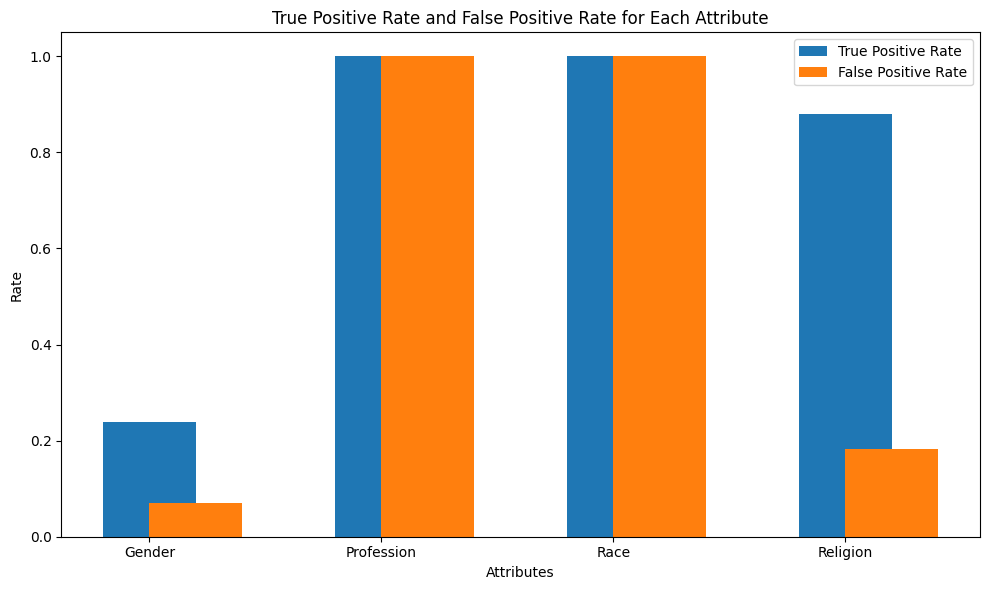

In [ ]:
# Attributes and their corresponding TPR and FPR values
attributes = [ 'Gender', 'Profession', 'Race', 'Religion']
tpr_values = [0.239, 1.000, 1.000, 0.879]
fpr_values = [0.071, 1.000, 1.000, 0.182]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot TPR and FPR for each attribute
ax.bar(attributes, tpr_values, width=0.4, label='True Positive Rate', align='center')
ax.bar(attributes, fpr_values, width=0.4, label='False Positive Rate', align='edge')

# Set the title and labels
ax.set_title('True Positive Rate and False Positive Rate for Each Attribute')
ax.set_xlabel('Attributes')
ax.set_ylabel('Rate')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()